In [1]:
import pandas as pd


url = "https://www.insee.fr/fr/statistiques/fichier/4648335/TF103.csv"

df = pd.read_csv(url, sep=";")

In [2]:
nameOfDiscriminatingColumn = "CSPR"
longNameOfDiscriminatingColumn = "socioeconomic category"
# create a dictionary with the translations
translations = {
    "1": "Farmers",
    "2": "Craftsmen, traders and business owners",
    "3": "Executives",
    "4": "Intermediate professions",
    "5": "Employees",
    "6": "Workers",
    "7": "Retirees",
    "8": "Other inactive"
}

# replace the values in the "STRATE" column with the corresponding translations
df[nameOfDiscriminatingColumn] = df[nameOfDiscriminatingColumn].replace(
    translations)

In [3]:
# filtering values with exactly 3 characters, corresponding to ECOICOP groups
df = df.loc[df['NOMENCLATURE'].str.len() == 3]

In [4]:
# filtering out rows where the "FCOIC" value starts with "13"
df = df.loc[~df['NOMENCLATURE'].str.startswith('13')]

Now let's deal with Eurostat inflation stats.

In [5]:
import eurostat

In [6]:
df_inflation = eurostat.get_data_df(code="PRC_HICP_MANR", filter_pars={
                                    'geo': 'FR', 'startPeriod': "2021-03"})
df_inflation = df_inflation.rename(columns={'geo\TIME_PERIOD': 'geo'})

In [7]:
# filter the rows using a regular expression, keeping only the ECOICOP groups (3 numbers)
df_inflation = df_inflation[df_inflation['coicop'].str.match(r'^CP\d{3}$')]

In [8]:
# remove the "CP" prefix from the values in the coicop column
df_inflation['coicop'] = df_inflation['coicop'].str.slice(start=2)

In [9]:
# keep only the specified columns using the .loc[] indexer
df_inflation = df_inflation.loc[:, ['coicop', '2022-03', '2023-03']]

In [10]:
# calculate the Cumulated inflation column based on the values in 2022-03 and 2023-03
df_inflation['Cumulated'] = (
    (1 + (df_inflation['2022-03'] / 100)) * (1 + (df_inflation['2023-03'] / 100))-1)*100

In [11]:
merged = pd.merge(df, df_inflation, left_on='NOMENCLATURE', right_on="coicop")

In [12]:
# calculating the sum of "CONSO" for each unique value in "AGPR" column
sum_by_strate = merged.groupby(nameOfDiscriminatingColumn)['CONSO'].sum()

In [13]:
# adding a new column "PROP" with the percentage of each row relative to the sum for each unique value in "AGPR" column
merged['PROP'] = merged['CONSO'] / \
    merged[nameOfDiscriminatingColumn].map(sum_by_strate)

Let's make sure sumPROP is equal to 1

In [14]:
sumPROP = merged.groupby(nameOfDiscriminatingColumn)['PROP'].sum()
sumPROP

CSPR
Craftsmen, traders and business owners    1.0
Employees                                 1.0
Executives                                1.0
Farmers                                   1.0
Intermediate professions                  1.0
Other inactive                            1.0
Retirees                                  1.0
TOT                                       1.0
Workers                                   1.0
Name: PROP, dtype: float64

In [15]:
# calculate the weight_Group_inflation_2022_03 column based on 2022-03 and PROP
merged['weight_Group_inflation_2022_03'] = merged['2022-03'] * merged['PROP']

In [16]:
# calculate the weight_Group_inflation_2023_03 column based on 2023-03 and PROP
merged['weight_Group_inflation_2023_03'] = merged['2023-03'] * merged['PROP']

In [17]:
# calculate the weight_Group_inflation_2023_03 column based on 2023-03 and PROP
merged['weight_Group_inflation_Cumulated'] = merged['Cumulated'] * merged['PROP']

In [18]:
sumInflationMarch2022 = merged.groupby(
    nameOfDiscriminatingColumn)['weight_Group_inflation_2022_03'].sum().to_frame()

In [19]:
sumInflationMarch2023 = merged.groupby(
    nameOfDiscriminatingColumn)['weight_Group_inflation_2023_03'].sum().to_frame()

In [20]:
sumCumulated = merged.groupby(
    nameOfDiscriminatingColumn)['weight_Group_inflation_Cumulated'].sum().to_frame()

Let's compute the difference with the ensemble

In [21]:
sumInflationMarch2022['diffTOT'] = sumInflationMarch2022["weight_Group_inflation_2022_03"] - \
    sumInflationMarch2022.loc['TOT']["weight_Group_inflation_2022_03"]
sumInflationMarch2022 = sumInflationMarch2022.drop(labels='TOT')

In [22]:
sumInflationMarch2023['diffTOT'] = sumInflationMarch2023["weight_Group_inflation_2023_03"] - \
    sumInflationMarch2023.loc['TOT']["weight_Group_inflation_2023_03"]
sumInflationMarch2023 = sumInflationMarch2023.drop(labels='TOT')

In [23]:
sumCumulated['diffTOT'] = sumCumulated["weight_Group_inflation_Cumulated"] - \
    sumCumulated.loc['TOT']["weight_Group_inflation_Cumulated"]
sumCumulated = sumCumulated.drop(labels='TOT')

In [24]:
sumAllThree = sumInflationMarch2022.merge(sumInflationMarch2023, on=nameOfDiscriminatingColumn, suffixes=[
                                          "_2022", "_2023"]).merge(sumCumulated, on=nameOfDiscriminatingColumn)

In [25]:
sumAllThree = sumAllThree.reindex(
    [translations[key] for key in sorted(translations.keys())])

C:\Users\mdaversa\AppData\Local\Temp\ipykernel_23944\2423865155.py:35: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig(f'saved_figs/figure12.png', dpi=500, bbox_inches='tight')
C:\Users\mdaversa\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


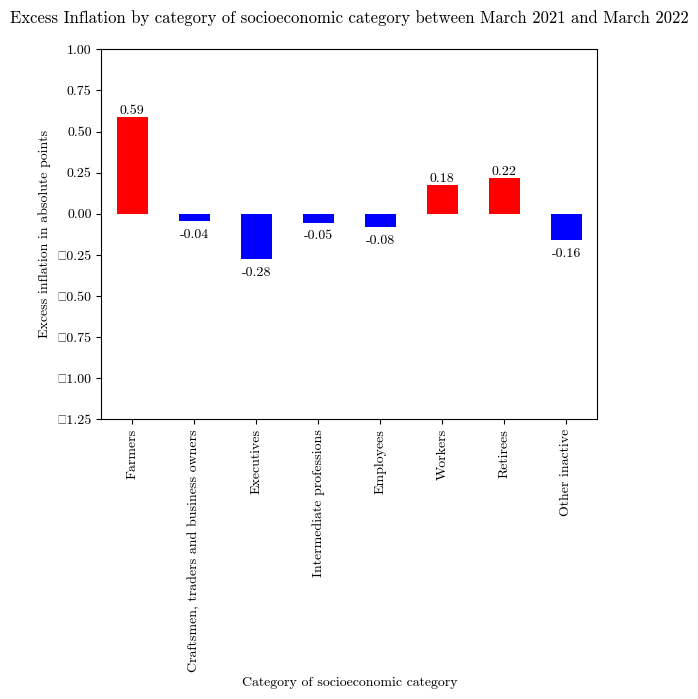

In [31]:
import matplotlib.pyplot as plt
# draw a bar chart


# define the colors based on the value of each bar
colors = ['red' if x > 0 else 'blue' for x in sumAllThree['diffTOT_2022']]


sumAllThree.plot.bar(y='diffTOT_2022', color=colors)

# set axis labels and title

plt.xlabel('Category of ' + longNameOfDiscriminatingColumn)
plt.ylabel('Excess inflation in absolute points')
plt.title('Excess Inflation by category of ' + longNameOfDiscriminatingColumn +
          ' between March 2021 and March 2022', y=1.05)

ylim_a = -1.25
ylim_b = 1
# set the y-axis scale to a specific range
plt.ylim(ylim_a, ylim_b)


# Add values to each bar
for i, v in enumerate(sumAllThree["diffTOT_2022"]):
    if v >= 0:
        plt.text(i, v+0.02, str(round(v,2)), ha='center', fontweight='bold')
    else:
        plt.text(i, v-0.1, str(round(v,2)), ha='center', fontweight='bold')

# remove the legend entirely
plt.legend(frameon=False, labels=[])

plt.rcParams['font.family'] = 'cmr10'
plt.savefig(f'saved_figs/figure12.png', dpi=500, bbox_inches='tight')

C:\Users\mdaversa\AppData\Local\Temp\ipykernel_23944\2601594933.py:29: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig(f'saved_figs/figure13.png', dpi=500, bbox_inches='tight')
C:\Users\mdaversa\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


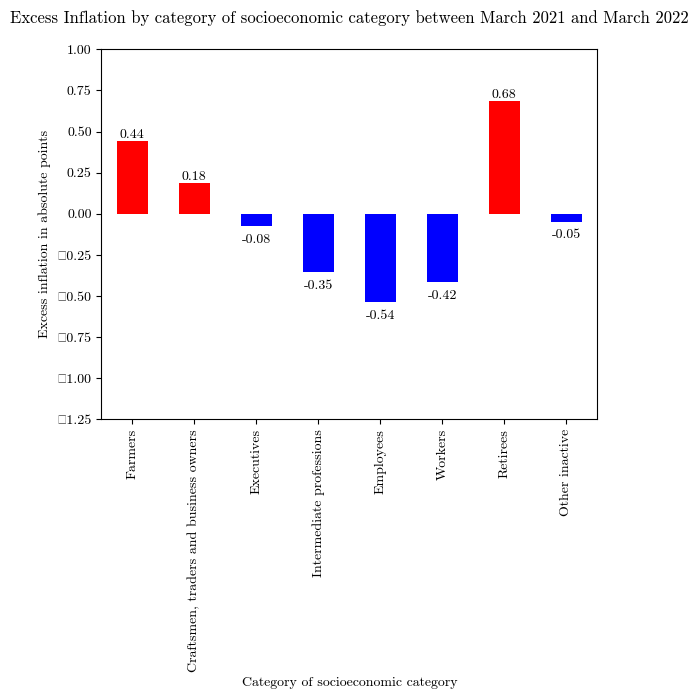

In [33]:
# define the colors based on the value of each bar
colors = ['red' if x > 0 else 'blue' for x in sumAllThree['diffTOT_2023']]


sumAllThree.plot.bar(y='diffTOT_2023', color=colors)

# set axis labels and title

plt.xlabel('Category of ' + longNameOfDiscriminatingColumn)
plt.ylabel('Excess inflation in absolute points')
plt.title('Excess Inflation by category of ' + longNameOfDiscriminatingColumn +
          ' between March 2021 and March 2022', y=1.05)

# set the y-axis scale to a specific range
plt.ylim(ylim_a, ylim_b)


# Add values to each bar
for i, v in enumerate(sumAllThree["diffTOT_2023"]):
    if v >= 0:
        plt.text(i, v+0.02, str(round(v,2)), ha='center', fontweight='bold')
    else:
        plt.text(i, v-0.1, str(round(v,2)), ha='center', fontweight='bold')

# remove the legend entirely
plt.legend(frameon=False, labels=[])

plt.rcParams['font.family'] = 'cmr10'
plt.savefig(f'saved_figs/figure13.png', dpi=500, bbox_inches='tight')

C:\Users\mdaversa\AppData\Local\Temp\ipykernel_23944\1716989375.py:28: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig(f'saved_figs/figure14.png', dpi=500, bbox_inches='tight')
C:\Users\mdaversa\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


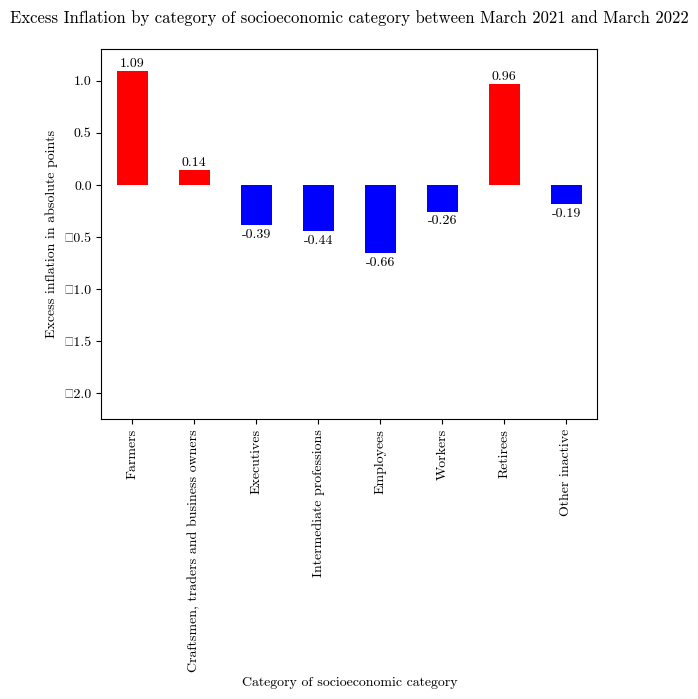

In [37]:
# define the colors based on the value of each bar
colors = ['red' if x > 0 else 'blue' for x in sumAllThree['diffTOT']]


sumAllThree.plot.bar(y='diffTOT', color=colors)

# set axis labels and title

plt.xlabel('Category of ' + longNameOfDiscriminatingColumn)
plt.ylabel('Excess inflation in absolute points')
plt.title('Excess Inflation by category of ' + longNameOfDiscriminatingColumn +
          ' between March 2021 and March 2022', y=1.05)

# set the y-axis scale to a specific range
plt.ylim(ylim_a - 1, ylim_b + 0.3)

# Add values to each bar
for i, v in enumerate(sumAllThree["diffTOT"]):
    if v >= 0:
        plt.text(i, v+0.04, str(round(v,2)), ha='center', fontweight='bold')
    else:
        plt.text(i, v-0.12, str(round(v,2)), ha='center', fontweight='bold')

# remove the legend entirely
plt.legend(frameon=False, labels=[])

plt.rcParams['font.family'] = 'cmr10'
plt.savefig(f'saved_figs/figure14.png', dpi=500, bbox_inches='tight')

In [29]:
sumInflationMarch2022.to_csv("computed_data/103_inflation_March_2022.csv")
